In [1]:
import pandas as pd
import numpy as np
import os
import multiprocessing as mp
from polyleven import levenshtein
import random 

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
library(ggplot2)

In [4]:
#Metadata import
metadata_fmba = pd.read_csv('/projects/fmba_covid/metadata_fmba_full_v2.txt', sep='\t')
metadata_fmba = metadata_fmba.rename(columns={"sample.COVID_status": "COVID_status"})

metadata_AB = pd.read_csv('../../random_forest_v2/AB_prediction/adaptive-metadata-edited.tsv', sep='\t')
metadata_AB["sample_short_name"] = metadata_AB["sample_name"].apply(lambda x: x[:-5]) #remove _TCRB from end of names

In [85]:
# Cohorts of downsampling data
#Make a cohorts of FMBA
fmba_healthy = set(metadata_fmba.loc[metadata_fmba.COVID_status == 'healthy', "CSP"])
print('fmba_healthy:', len(fmba_healthy))
fmba_IgM_yes = set(metadata_fmba.loc[metadata_fmba['sample.COVID_IgM'] == 'yes', "CSP"])
print('fmba_IgM_yes:', len(fmba_IgM_yes))
fmba_IgM_no_IgG_yes = set(metadata_fmba.loc[(metadata_fmba['sample.COVID_IgM'] == 'no')
                       & (metadata_fmba['sample.COVID_IgG'] == 'yes'), "CSP"])
print('fmba_IgM_no_IgG_yes:', len(fmba_IgM_no_IgG_yes))

#Make a cohorts of Adaptive
AB_acute = set(metadata_AB.loc[(metadata_AB["COVID-19-status"]=='acute', "sample_short_name")])
print('AB_acute:', len(AB_acute))
AB_recovered = set(metadata_AB.loc[(metadata_AB["COVID-19-status"]=='recovered', "sample_short_name")])
print('AB_recovered:', len(AB_recovered))
AB_baseline = set(metadata_AB.loc[(metadata_AB["COVID-19-status"]=='baseline', "sample_short_name")])
print('AB_baseline:', len(AB_baseline))
AB_exposed = set(metadata_AB.loc[(metadata_AB["COVID-19-status"]=='exposed', "sample_short_name")])
print('AB_exposed:', len(AB_exposed))

#HIP cohort
hip = set([i[: -4] for i in os.listdir('../../random_forest_v2/hip_corr_functional_random2000AA') if i.startswith("HIP")])
print('HIP:', len(hip))
#Keck cohort
Keck = set([i[: -4] for i in os.listdir('../../random_forest_v2/hip_corr_functional_random2000AA') if i.startswith("Keck")])
print('Keck:', len(Keck))

fmba_healthy: 409
fmba_IgM_yes: 410
fmba_IgM_no_IgG_yes: 340
AB_acute: 1140
AB_recovered: 239
AB_baseline: 74
AB_exposed: 26
HIP: 664
Keck: 119


In [5]:
#Cohorts of initial data
#Make a cohorts of FMBA initial data
fmba_healthy = set(metadata_fmba.loc[metadata_fmba.COVID_status == 'healthy', "CSP"])
print('fmba_healthy:', len(fmba_healthy))
fmba_IgM_yes = set(metadata_fmba.loc[metadata_fmba['sample.COVID_IgM'] == 'yes', "CSP"])
print('fmba_IgM_yes:', len(fmba_IgM_yes))
fmba_IgM_no_IgG_yes = set(metadata_fmba.loc[(metadata_fmba['sample.COVID_IgM'] == 'no')
                       & (metadata_fmba['sample.COVID_IgG'] == 'yes'), "CSP"])
print('fmba_IgM_no_IgG_yes:', len(fmba_IgM_no_IgG_yes))

#Make a cohorts of Adaptive
AB_acute = set(metadata_AB.loc[(metadata_AB["COVID-19-status"]=='acute', "sample_short_name")])
print('AB_acute:', len(AB_acute))
AB_recovered = set(metadata_AB.loc[(metadata_AB["COVID-19-status"]=='recovered', "sample_short_name")])
print('AB_recovered:', len(AB_recovered))
AB_baseline = set(metadata_AB.loc[(metadata_AB["COVID-19-status"]=='baseline', "sample_short_name")])
print('AB_baseline:', len(AB_baseline))
AB_exposed = set(metadata_AB.loc[(metadata_AB["COVID-19-status"]=='exposed', "sample_short_name")])
print('AB_exposed:', len(AB_exposed))

#HIP cohort
hip = set([i[: -4] for i in os.listdir('/projects/fmba_covid/hip_full/corr') if i.startswith("HIP")])
print('HIP:', len(hip))
#Keck cohort
Keck = set([i[: -4] for i in os.listdir('/projects/fmba_covid/hip_full/corr') if i.startswith("Keck")])
print('Keck:', len(Keck))

fmba_healthy: 409
fmba_IgM_yes: 410
fmba_IgM_no_IgG_yes: 340
AB_acute: 1140
AB_recovered: 239
AB_baseline: 74
AB_exposed: 26
HIP: 666
Keck: 120


In [9]:
#Import public clones
pool_AB=pd.read_csv("/projects/fmba_covid/adaptive_new/pool/pool.aa.table.20+.txt", sep = '\t') 
pool_FMBA=pd.read_csv("/projects/fmba_covid/fmba_new/pool/TRB.pool.aa.table.txt", sep = '\t') \

random_clones_AB=[x for x in  list(pool_AB.cdr3aa) if '_' not in x] 
random_clones_AB=random.sample(random_clones_AB, 1000)

random_clones_FMBA=[x for x in  list(pool_FMBA.cdr3aa) if '_' not in x] 
random_clones_FMBA=random.sample(random_clones_FMBA, 1000)

In [6]:
#import associated clones
associated_clones_fmba = pd.read_csv('../../fmba/COVID_status_TRB_fmba_full_v2_pv.txt', sep='\t')
associated_clones_fmba = list(associated_clones_fmba.cdr3aa)[:1000]

associated_clones_AB = pd.read_csv('../../adaptive/covid_status_top.txt', sep='\t')
associated_clones_AB = list(associated_clones_AB.cdr3aa)[:1000]

associated_clones_AB_FMBA = pd.read_csv("../graph_leven_distance/incidence_of_features_AB_vs_FMBA_sorted.tsv", sep = '\t', index_col=0)
associated_clones_AB_FMBA=list(associated_clones_AB_FMBA.index.values) 
associated_clones_AB_FMBA=[x for x in associated_clones_AB_FMBA if '_' not in x]
associated_clones_AB_FMBA=associated_clones_AB_FMBA[:1000]

associated_clones_fmba_trb_ttest=pd.read_csv("../../fmba/FMBA_TRB_sign_clones_ttest_top2000.tsv", sep="\t",index_col=0)
associated_clones_fmba_trb_ttest=list(associated_clones_fmba_trb_ttest.index.values)[:1000]

associated_clones_fmba_tra_ttest=pd.read_csv("../../fmba/FMBA_TRA_sign_clones_ttest_top2000.tsv", sep="\t",index_col=0)
associated_clones_fmba_tra_ttest=list(associated_clones_fmba_tra_ttest.index.values)[:1000]

associated_clones_fmba_tra_fisher=pd.read_csv("../../fmba/COVID_status_TRA_fmba_full_v2_pv.txt", sep="\t",index_col=0)
associated_clones_fmba_tra_fisher=list(associated_clones_fmba_tra_fisher.index.values)[:200]

In [14]:
#Get features frequences by levenshtein
def get_features_frequences_levenshtein1(sample_name, path_to_folder_with_sample, clones_for_analyse):
    #------read clonotype tabel    
    with open(str(path_to_folder_with_sample)+"/"+str(sample_name),"r") as clonotype_file:
        total_counts=0
        clone_counts=0
        for clone in clonotype_file.readlines()[1:]: #skip header
            clone=clone.strip().split("\t")
            total_counts+=1 
            #zero or one mismatch/indel (clone[2] is amino acid CDR3 sequence)
            for feature_of_interest in clones_for_analyse:
                if levenshtein(feature_of_interest, clone[2], 1)<=1: #!!!FUNCTION FOR UPPER BOUNDED LEVENSHTIEN!!!
                    clone_counts+=1 
    total_freq = clone_counts/(total_counts*10)
    return total_freq

In [8]:
#Get features frequences without mismath 
def get_features_frequences(sample_name, path_to_folder_with_sample, clones_for_analyse):
    #------read clonotype tabel    
    with open(str(path_to_folder_with_sample)+"/"+str(sample_name),"r") as clonotype_file:
        total_counts=0
        clone_counts=0
        for clone in clonotype_file.readlines()[1:]: #skip header
            clone=clone.strip().split("\t")
            total_counts+=1
            if total_counts > treshhold:
                break
            #zero or one mismatch/indel (clone[2] is amino acid CDR3 sequence)
            for feature_of_interest in clones_for_analyse:
                if feature_of_interest == clone[3]:
                    clone_counts+=1 
    total_freq = clone_counts/(2000*10)
    return total_freq

In [19]:
#Hamming distance
# Return the Hamming distance between string1 and string2.
def hamming_distance(string1, string2): 
    if len(string1)!=len(string2): 
        return 10 
        
    else: 
    # Start with a distance of zero, and count up
            distance = 0
            # Loop over the indices of the string
            L = len(string1)
            for i in range(L):
                # Add 1 to the distance if these two characters are not equal
                if string1[i] != string2[i]:
                    distance += 1
            return distance
                    
# Return the final count of differences    

In [20]:
#Get features frequences by Hamming distance
def get_features_frequences_hamming(sample_name, path_to_folder_with_sample, clones_for_analyse):
    #------read clonotype tabel    
    with open(str(path_to_folder_with_sample)+"/"+str(sample_name),"r") as clonotype_file:
        total_counts=0
        clone_counts=0
        for clone in clonotype_file.readlines()[1:]: #skip header
            clone=clone.strip().split("\t")
            total_counts+=1
            if total_counts > treshhold:
                break
            #zero or one mismatch/indel (clone[2] is amino acid CDR3 sequence)
            for feature_of_interest in clones_for_analyse:
                if hamming_distance(feature_of_interest, clone[3])<=1: #!!!FUNCTION FOR UPPER BOUNDED LEVENSHTIEN!!!
                    clone_counts+=1 
    total_freq = clone_counts/(2000*2)
    return total_freq

#### Get FMBA features frequences in FMBA data

In [104]:
%%time
treshhold=2000
#folder_with_samples = "../../random_forest_v2/fmba_new_corr_TRB_functional_random2000AA"


#----------read sample names----------
#samples=pd.read_csv(str(folder_with_samples)+"/metadata.txt",sep="\t",
#                  header=None)
#samples=list(samples[0])
#-------------------------------------
folder_with_samples="/projects/fmba_covid/fmba_new/corr"
chain="TRB"

#----------read sample names----------
samples=[i for i in os.listdir(folder_with_samples) if i.endswith(f"{chain}.txt")]
#-------------------------------------




def get_features_frequences_wrapper(sample_name,
                                                   path_to_folder_with_sample=folder_with_samples,
                                                   clones_for_analyse=associated_clones_fmba):
    return  get_features_frequences(sample_name,
                                                  path_to_folder_with_sample=path_to_folder_with_sample,
                                                  clones_for_analyse=clones_for_analyse)




#result=list(map(get_features_frequences_levenshtein1_wrapper, samples))
print("START")    
pool = mp.Pool(processes = (mp.cpu_count())) #SET THE NUMBER OF CORES THAT YOU GOING TO USE
results=pool.map(get_features_frequences_wrapper, samples)
pool.close()
clones_in_samples=list(results)
print("DONE")

START
DONE
CPU times: user 315 ms, sys: 1.82 s, total: 2.14 s
Wall time: 11.9 s


In [105]:
samples_short_names = list(map(lambda x: int(x[:12]), samples)) 
fmba_feat_freq_fmba = pd.DataFrame({'feature frequency': clones_in_samples}, index = samples_short_names)
fmba_feat_freq_fmba.index.name='sample_name'
fmba_feat_freq_fmba.to_csv('fmba_feat_freq_fmba.tsv', sep = '\t')

#### Get FMBA features frequences in Adaptive data

In [106]:
%%time
#folder_with_samples = "../../random_forest_v2/AB_corr_functional_random2000AA"


#----------read sample names----------
#samples=pd.read_csv(str(folder_with_samples)+"/metadata.txt",sep="\t",
#                   header=None)
#samples=list(samples[0])
#-------------------------------------
folder_with_samples="/projects/fmba_covid/adaptive_new/corr"


#----------read sample names----------
samples=os.listdir(folder_with_samples)
#-------------------------------------


def get_features_frequences_wrapper(sample_name,
                                                   path_to_folder_with_sample=folder_with_samples,
                                                   clones_for_analyse=associated_clones_fmba ):
    return  get_features_frequences(sample_name,
                                                  path_to_folder_with_sample=path_to_folder_with_sample,
                                                  clones_for_analyse=clones_for_analyse)




#result=list(map(get_features_frequences_levenshtein1_wrapper, samples))
print("START")    
pool = mp.Pool(processes = (mp.cpu_count())) #SET THE NUMBER OF CORES THAT YOU GOING TO USE
results=pool.map(get_features_frequences_wrapper, samples)
pool.close()
clones_in_samples=list(results)
print("DONE")


START
DONE
CPU times: user 760 ms, sys: 3.51 s, total: 4.27 s
Wall time: 35.8 s


In [107]:
samples_short_names = list(map(lambda x: x[: -13], samples)) 
fmba_feat_freq_AB = pd.DataFrame({'feature frequency': clones_in_samples}, index = samples_short_names)
fmba_feat_freq_AB.index.name='sample_name'
fmba_feat_freq_AB.to_csv('fmba_feat_freq_AB.tsv', sep = '\t')

#### Get FMBA features frequences in HIP and Keck data

In [108]:
%%time
folder_with_samples="/projects/fmba_covid/hip_full/corr"


#----------read sample names----------
samples=os.listdir(folder_with_samples)
#-------------------------------------



def get_features_frequences_wrapper(sample_name,
                                                   path_to_folder_with_sample=folder_with_samples,
                                                   clones_for_analyse=associated_clones_fmba ):
    return  get_features_frequences(sample_name,
                                                  path_to_folder_with_sample=path_to_folder_with_sample,
                                                  clones_for_analyse=clones_for_analyse)




#result=list(map(get_features_frequences_levenshtein1_wrapper, samples))
print("START")    
pool = mp.Pool(processes = (mp.cpu_count())) #SET THE NUMBER OF CORES THAT YOU GOING TO USE
results=pool.map(get_features_frequences_wrapper, samples)
pool.close()
clones_in_samples=list(results)
print("DONE")

START
DONE
CPU times: user 386 ms, sys: 2.16 s, total: 2.55 s
Wall time: 16.8 s


In [109]:
samples_short_names = list(map(lambda x: x[: -4], samples)) 
fmba_feat_freq_HIP_Keck = pd.DataFrame({'feature frequency': clones_in_samples}, index = samples_short_names)
fmba_feat_freq_HIP_Keck.index.name='sample_name'
fmba_feat_freq_HIP_Keck.to_csv('fmba_feat_freq_HIP_Keck.tsv', sep = '\t')

In [110]:
#concat dataframes
fmba_feat_freq_all_data = pd.concat([fmba_feat_freq_fmba, fmba_feat_freq_AB, fmba_feat_freq_HIP_Keck], axis=0)

#Make a column with cohorts
fmba_feat_freq_all_data['cohorts'] = 'FMBA_healthy'
fmba_feat_freq_all_data.loc[set(fmba_feat_freq_all_data.index.values)&fmba_IgM_yes, 'cohorts'] = 'FMBA_IgM+'
fmba_feat_freq_all_data.loc[set(fmba_feat_freq_all_data.index.values)&fmba_IgM_no_IgG_yes, 'cohorts'] = 'FMBA_IgM-_IgG+'
fmba_feat_freq_all_data.loc[set(fmba_feat_freq_all_data.index.values)&AB_acute, 'cohorts'] = 'AB_acute'
fmba_feat_freq_all_data.loc[set(fmba_feat_freq_all_data.index.values)&AB_recovered, 'cohorts'] = 'AB_recovered'
fmba_feat_freq_all_data.loc[set(fmba_feat_freq_all_data.index.values)&AB_exposed, 'cohorts'] = 'AB_exposed'
fmba_feat_freq_all_data.loc[set(fmba_feat_freq_all_data.index.values)&hip, 'cohorts'] = 'HIP'
fmba_feat_freq_all_data.loc[set(fmba_feat_freq_all_data.index.values)&Keck, 'cohorts'] = 'Keck'
#fmba_healthy: 409
#fmba_IgM_yes: 410
#fmba_IgM_no_IgG_yes: 340
#AB_acute: 1140
#AB_recovered: 239
#AB_baseline: 74
#AB_exposed: 26
#HIP: 664
#Keck: 119
fmba_feat_freq_all_data.to_csv('fmba_feat_freq_all_cohorts.tsv', sep = '\t')

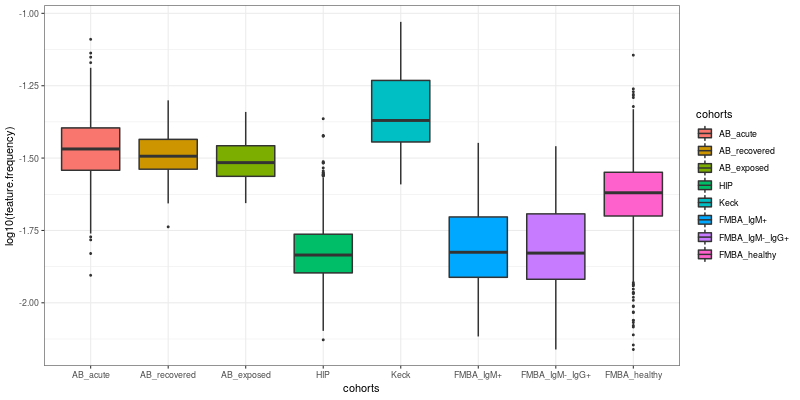

In [163]:
%%R -w 800 -h 400
fmba_feat_freq_all_data=read.csv('fmba_feat_freq_all_cohorts.tsv', sep="\t", header=TRUE)
fmba_feat_freq_all_data$cohorts=factor(fmba_feat_freq_all_data$cohorts,  
                                       levels=c("AB_acute", "AB_recovered", "AB_exposed", "HIP",
                                                   "Keck", "FMBA_IgM+", "FMBA_IgM-_IgG+", "FMBA_healthy"))
ggplot(fmba_feat_freq_all_data, aes(x=cohorts, y=log10(feature.frequency), fill=cohorts) ) + 
  geom_boxplot( notch=FALSE,outlier.size = 0.7, lwd=0.7) + theme_bw()

#Features - FMBA, all cohorts (leven1)

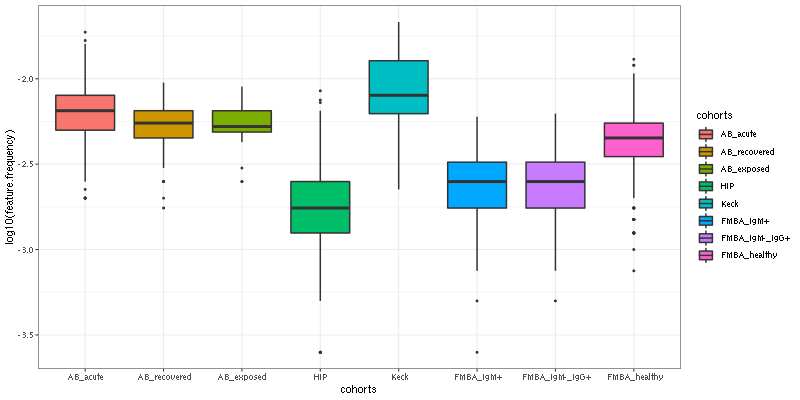

In [88]:
%%R -w 800 -h 400
fmba_feat_freq_all_data=read.csv('fmba_feat_freq_all_cohorts.tsv', sep="\t", header=TRUE)
fmba_feat_freq_all_data$cohorts=factor(fmba_feat_freq_all_data$cohorts,  
                                       levels=c("AB_acute", "AB_recovered", "AB_exposed", "HIP",
                                                   "Keck", "FMBA_IgM+", "FMBA_IgM-_IgG+", "FMBA_healthy"))
ggplot(fmba_feat_freq_all_data, aes(x=cohorts, y=log10(feature.frequency), fill=cohorts) ) + 
  geom_boxplot( notch=FALSE,outlier.size = 0.7, lwd=0.7) + theme_bw()

#Features - FMBA, all cohorts (without mismathes)

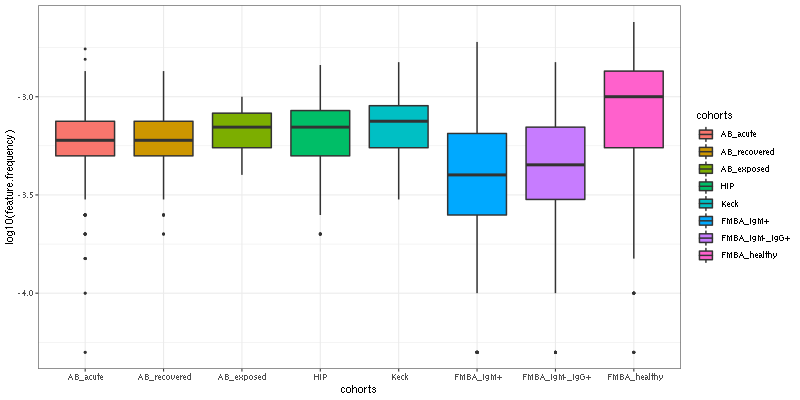

In [111]:
%%R -w 800 -h 400
fmba_feat_freq_all_data=read.csv('fmba_feat_freq_all_cohorts.tsv', sep="\t", header=TRUE)
fmba_feat_freq_all_data$cohorts=factor(fmba_feat_freq_all_data$cohorts,  
                                       levels=c("AB_acute", "AB_recovered", "AB_exposed", "HIP",
                                                   "Keck", "FMBA_IgM+", "FMBA_IgM-_IgG+", "FMBA_healthy"))
ggplot(fmba_feat_freq_all_data, aes(x=cohorts, y=log10(feature.frequency), fill=cohorts) ) + 
  geom_boxplot( notch=FALSE,outlier.size = 0.7, lwd=0.7) + theme_bw()

#Features - FMBA, all cohorts (without mismathes, initial data)

#### Get AB features frequences in FMBA data

In [20]:
%%time
folder_with_samples = "../../random_forest_v2/fmba_new_corr_TRB_functional_random2000AA"


#----------read sample names----------
samples=pd.read_csv(str(folder_with_samples)+"/metadata.txt",sep="\t",
                   header=None)
samples=list(samples[0])
#-------------------------------------


def get_features_frequences_levenshtein1_wrapper(sample_name,
                                                   path_to_folder_with_sample=folder_with_samples,
                                                   clones_for_analyse=associated_clones_AB):
    return  get_features_frequences_levenshtein1(sample_name,
                                                  path_to_folder_with_sample=path_to_folder_with_sample,
                                                  clones_for_analyse=clones_for_analyse)




#result=list(map(get_features_frequences_levenshtein1_wrapper, samples))
print("START")    
pool = mp.Pool(processes = (mp.cpu_count())) #SET THE NUMBER OF CORES THAT YOU GOING TO USE
results=pool.map(get_features_frequences_levenshtein1_wrapper, samples)
pool.close()
clones_in_samples=list(results)
print("DONE")

START
DONE
CPU times: user 48.5 ms, sys: 65.1 ms, total: 114 ms
Wall time: 1min 1s


In [21]:
samples_short_names = list(map(lambda x: int(x[:12]), samples)) 
AB_feat_freq_fmba = pd.DataFrame({'feature frequency': clones_in_samples}, index = samples_short_names)
AB_feat_freq_fmba.index.name='sample_name'
AB_feat_freq_fmba.to_csv('AB_feat_freq_fmba.tsv', sep = '\t')

#### Get AB features frequences in Adaptive data

In [22]:
%%time
folder_with_samples = "../../random_forest_v2/AB_corr_functional_random2000AA"


#----------read sample names----------
samples=pd.read_csv(str(folder_with_samples)+"/metadata.txt",sep="\t",
                   header=None)
samples=list(samples[0])
#-------------------------------------


def get_features_frequences_levenshtein1_wrapper(sample_name,
                                                   path_to_folder_with_sample=folder_with_samples,
                                                   clones_for_analyse=associated_clones_AB):
    return  get_features_frequences_levenshtein1(sample_name,
                                                  path_to_folder_with_sample=path_to_folder_with_sample,
                                                  clones_for_analyse=clones_for_analyse)




#result=list(map(get_features_frequences_levenshtein1_wrapper, samples))
print("START")    
pool = mp.Pool(processes = (mp.cpu_count())) #SET THE NUMBER OF CORES THAT YOU GOING TO USE
results=pool.map(get_features_frequences_levenshtein1_wrapper, samples)
pool.close()
clones_in_samples=list(results)
print("DONE")

START
DONE
CPU times: user 44.9 ms, sys: 82.3 ms, total: 127 ms
Wall time: 1min 45s


In [24]:
samples_short_names = list(map(lambda x: x[: -13], samples)) 
AB_feat_freq_AB = pd.DataFrame({'feature frequency': clones_in_samples}, index = samples_short_names)
AB_feat_freq_AB.index.name='sample_name'
AB_feat_freq_AB.to_csv('AB_feat_freq_AB.tsv', sep = '\t')

#### Get AB features frequences in HIP and Keck data¶

In [25]:
%%time
folder_with_samples = "../../random_forest_v2/hip_corr_functional_random2000AA"


#----------read sample names----------
samples=pd.read_csv(str(folder_with_samples)+"/metadata.txt",sep="\t",
                   header=None)
samples=list(samples[0])
#-------------------------------------


def get_features_frequences_levenshtein1_wrapper(sample_name,
                                                   path_to_folder_with_sample=folder_with_samples,
                                                   clones_for_analyse=associated_clones_AB):
    return  get_features_frequences_levenshtein1(sample_name,
                                                  path_to_folder_with_sample=path_to_folder_with_sample,
                                                  clones_for_analyse=clones_for_analyse)




#result=list(map(get_features_frequences_levenshtein1_wrapper, samples))
print("START")    
pool = mp.Pool(processes = (mp.cpu_count())) #SET THE NUMBER OF CORES THAT YOU GOING TO USE
results=pool.map(get_features_frequences_levenshtein1_wrapper, samples)
pool.close()
clones_in_samples=list(results)
print("DONE")

START
DONE
CPU times: user 42.7 ms, sys: 74.5 ms, total: 117 ms
Wall time: 1min


In [26]:
samples_short_names = list(map(lambda x: x[: -4], samples)) 
AB_feat_freq_HIP_Keck = pd.DataFrame({'feature frequency': clones_in_samples}, index = samples_short_names)
AB_feat_freq_HIP_Keck.index.name='sample_name'
AB_feat_freq_HIP_Keck.to_csv('AB_feat_freq_HIP_Keck.tsv', sep = '\t')

In [27]:
#concat dataframes
AB_feat_freq_all_data = pd.concat([AB_feat_freq_fmba, AB_feat_freq_AB, AB_feat_freq_HIP_Keck], axis=0)

#Make a column with cohorts
AB_feat_freq_all_data['cohorts'] = 'FMBA_healthy'
AB_feat_freq_all_data.loc[set(AB_feat_freq_all_data.index.values)&fmba_IgM_yes, 'cohorts'] = 'FMBA_IgM+'
AB_feat_freq_all_data.loc[set(AB_feat_freq_all_data.index.values)&fmba_IgM_no_IgG_yes, 'cohorts'] = 'FMBA_IgM-_IgG+'
AB_feat_freq_all_data.loc[set(AB_feat_freq_all_data.index.values)&AB_acute, 'cohorts'] = 'AB_acute'
AB_feat_freq_all_data.loc[set(AB_feat_freq_all_data.index.values)&AB_recovered, 'cohorts'] = 'AB_recovered'
AB_feat_freq_all_data.loc[set(AB_feat_freq_all_data.index.values)&AB_exposed, 'cohorts'] = 'AB_exposed'
AB_feat_freq_all_data.loc[set(AB_feat_freq_all_data.index.values)&hip, 'cohorts'] = 'HIP'
AB_feat_freq_all_data.loc[set(AB_feat_freq_all_data.index.values)&Keck, 'cohorts'] = 'Keck'
#fmba_healthy: 409
#fmba_IgM_yes: 410
#fmba_IgM_no_IgG_yes: 340
#AB_acute: 1140
#AB_recovered: 239
#AB_baseline: 74
#AB_exposed: 26
#HIP: 664
#Keck: 119
AB_feat_freq_all_data.to_csv('AB_feat_freq_all_cohorts.tsv', sep = '\t')

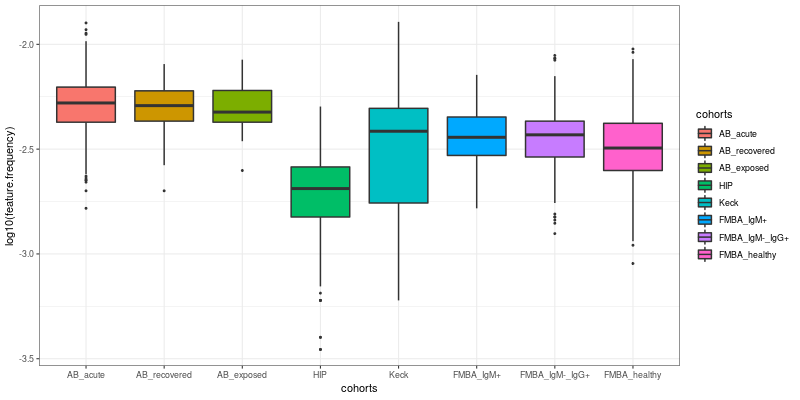

In [89]:
%%R -w 800 -h 400
AB_feat_freq_all_data=read.csv('AB_feat_freq_all_cohorts.tsv', sep="\t", header=TRUE)
AB_feat_freq_all_data$cohorts=factor(AB_feat_freq_all_data$cohorts,  
                                     levels=c("AB_acute", "AB_recovered", "AB_exposed", "HIP",
                                                   "Keck", "FMBA_IgM+", "FMBA_IgM-_IgG+", "FMBA_healthy"))
ggplot(AB_feat_freq_all_data, aes(x=cohorts, y=log10(feature.frequency), fill=cohorts) ) + 
  geom_boxplot( notch=FALSE,outlier.size = 0.7, lwd=0.7) + theme_bw()

#Features - AB, all cohorts

In [42]:
fmba_feat_freq_all_data['features']='FMBA_features'
AB_feat_freq_all_data['features']='AB_features'
fmba_AB_feat_freq_all_data=pd.concat([fmba_feat_freq_all_data, AB_feat_freq_all_data], axis=0)
fmba_AB_feat_freq_all_data.to_csv('FMBA_AB_feat_freq_all_cohorts.tsv', sep = '\t')

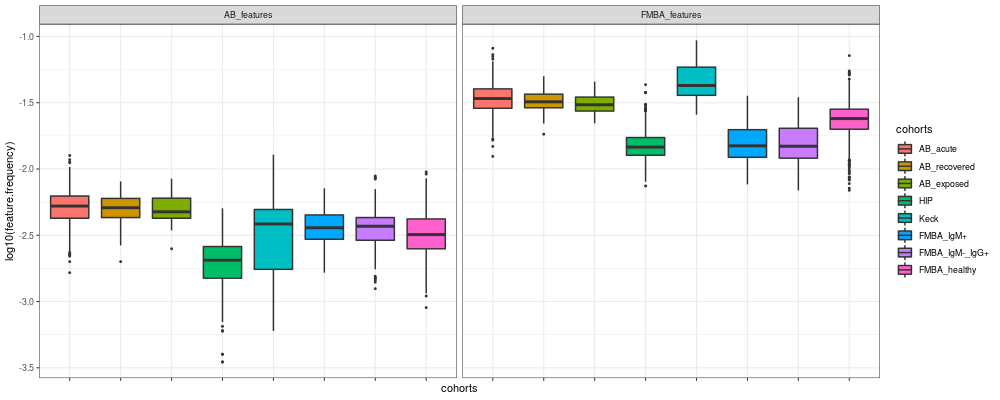

In [88]:
%%R -w 1000 -h 400
fmba_AB_feat_freq_all_data=read.csv('FMBA_AB_feat_freq_all_cohorts.tsv', sep="\t", header=TRUE)
fmba_AB_feat_freq_all_data$cohorts=factor(fmba_AB_feat_freq_all_data$cohorts,  
                                             levels=c("AB_acute", "AB_recovered", "AB_exposed", "HIP",
                                                   "Keck", "FMBA_IgM+", "FMBA_IgM-_IgG+", "FMBA_healthy"))
fmba_AB_feat_freq_all_data$features=as.factor(fmba_AB_feat_freq_all_data$features)


    
ggplot(fmba_AB_feat_freq_all_data, aes(x=cohorts, y=log10(feature.frequency), fill=cohorts) ) + 
  geom_boxplot( notch=FALSE,outlier.size = 0.7, lwd=0.7) + facet_wrap(~features, nrow=1) + theme_bw() + theme(axis.text.x=element_blank())
    

### AB-FMBA mix features

#### Get AB-FMBA features frequences in FMBA data

In [69]:
%%time
folder_with_samples = "../../random_forest_v2/fmba_new_corr_TRB_functional_random2000AA"


#----------read sample names----------
samples=pd.read_csv(str(folder_with_samples)+"/metadata.txt",sep="\t",
                   header=None)
samples=list(samples[0])
#-------------------------------------


def get_features_frequences_levenshtein1_wrapper(sample_name,
                                                   path_to_folder_with_sample=folder_with_samples,
                                                   clones_for_analyse=associated_clones_AB_FMBA):
    return  get_features_frequences_levenshtein1(sample_name,
                                                  path_to_folder_with_sample=path_to_folder_with_sample,
                                                  clones_for_analyse=clones_for_analyse)




#result=list(map(get_features_frequences_levenshtein1_wrapper, samples))
print("START")    
pool = mp.Pool(processes = (mp.cpu_count())) #SET THE NUMBER OF CORES THAT YOU GOING TO USE
results=pool.map(get_features_frequences_levenshtein1_wrapper, samples)
pool.close()
clones_in_samples=list(results)
print("DONE")

START
DONE
CPU times: user 31.2 ms, sys: 101 ms, total: 132 ms
Wall time: 1min 1s


In [70]:
samples_short_names = list(map(lambda x: int(x[:12]), samples)) 
AB_fmba_feat_freq_fmba = pd.DataFrame({'feature frequency': clones_in_samples}, index = samples_short_names)
AB_fmba_feat_freq_fmba.index.name='sample_name'
AB_fmba_feat_freq_fmba.to_csv('AB_fmba_feat_freq_fmba.tsv', sep = '\t')

#### Get AB-FMBA features frequences in Adaptive data

In [71]:
%%time
folder_with_samples = "../../random_forest_v2/AB_corr_functional_random2000AA"


#----------read sample names----------
samples=pd.read_csv(str(folder_with_samples)+"/metadata.txt",sep="\t",
                   header=None)
samples=list(samples[0])
#-------------------------------------


def get_features_frequences_levenshtein1_wrapper(sample_name,
                                                   path_to_folder_with_sample=folder_with_samples,
                                                   clones_for_analyse=associated_clones_AB_FMBA):
    return  get_features_frequences_levenshtein1(sample_name,
                                                  path_to_folder_with_sample=path_to_folder_with_sample,
                                                  clones_for_analyse=clones_for_analyse)




#result=list(map(get_features_frequences_levenshtein1_wrapper, samples))
print("START")    
pool = mp.Pool(processes = (mp.cpu_count())) #SET THE NUMBER OF CORES THAT YOU GOING TO USE
results=pool.map(get_features_frequences_levenshtein1_wrapper, samples)
pool.close()
clones_in_samples=list(results)
print("DONE")

START
DONE
CPU times: user 74.3 ms, sys: 83.3 ms, total: 158 ms
Wall time: 1min 46s


In [73]:
samples_short_names = list(map(lambda x: x[: -13], samples)) 
AB_fmba_feat_freq_AB = pd.DataFrame({'feature frequency': clones_in_samples}, index = samples_short_names)
AB_fmba_feat_freq_AB.index.name='sample_name'
AB_fmba_feat_freq_AB.to_csv('AB_fmba_feat_freq_AB.tsv', sep = '\t')

#### Get AB-FMBA features frequences in HIP and Keck data¶¶

In [74]:
%%time
folder_with_samples = "../../random_forest_v2/hip_corr_functional_random2000AA"


#----------read sample names----------
samples=pd.read_csv(str(folder_with_samples)+"/metadata.txt",sep="\t",
                   header=None)
samples=list(samples[0])
#-------------------------------------


def get_features_frequences_levenshtein1_wrapper(sample_name,
                                                   path_to_folder_with_sample=folder_with_samples,
                                                   clones_for_analyse=associated_clones_AB_FMBA):
    return  get_features_frequences_levenshtein1(sample_name,
                                                  path_to_folder_with_sample=path_to_folder_with_sample,
                                                  clones_for_analyse=clones_for_analyse)




#result=list(map(get_features_frequences_levenshtein1_wrapper, samples))
print("START")    
pool = mp.Pool(processes = (mp.cpu_count())) #SET THE NUMBER OF CORES THAT YOU GOING TO USE
results=pool.map(get_features_frequences_levenshtein1_wrapper, samples)
pool.close()
clones_in_samples=list(results)
print("DONE")

START
DONE
CPU times: user 38.9 ms, sys: 93.2 ms, total: 132 ms
Wall time: 1min


In [79]:
samples_short_names = list(map(lambda x: x[: -4], samples)) 
AB_fmba_feat_freq_HIP_Keck = pd.DataFrame({'feature frequency': clones_in_samples}, index = samples_short_names)
AB_fmba_feat_freq_HIP_Keck.index.name='sample_name'
AB_fmba_feat_freq_HIP_Keck.to_csv('AB_fmba_feat_freq_HIP_Keck.tsv', sep = '\t')

In [80]:
#concat dataframes
AB_fmba_feat_freq_all_data = pd.concat([AB_fmba_feat_freq_fmba, AB_fmba_feat_freq_AB, AB_fmba_feat_freq_HIP_Keck], axis=0)

#Make a column with cohorts
AB_fmba_feat_freq_all_data['cohorts'] = 'FMBA_healthy'
AB_fmba_feat_freq_all_data.loc[set(AB_fmba_feat_freq_all_data.index.values)&fmba_IgM_yes, 'cohorts'] = 'FMBA_IgM+'
AB_fmba_feat_freq_all_data.loc[set(AB_fmba_feat_freq_all_data.index.values)&fmba_IgM_no_IgG_yes, 'cohorts'] = 'FMBA_IgM-_IgG+'
AB_fmba_feat_freq_all_data.loc[set(AB_fmba_feat_freq_all_data.index.values)&AB_acute, 'cohorts'] = 'AB_acute'
AB_fmba_feat_freq_all_data.loc[set(AB_fmba_feat_freq_all_data.index.values)&AB_recovered, 'cohorts'] = 'AB_recovered'
AB_fmba_feat_freq_all_data.loc[set(AB_fmba_feat_freq_all_data.index.values)&AB_exposed, 'cohorts'] = 'AB_exposed'
AB_fmba_feat_freq_all_data.loc[set(AB_fmba_feat_freq_all_data.index.values)&hip, 'cohorts'] = 'HIP'
AB_fmba_feat_freq_all_data.loc[set(AB_fmba_feat_freq_all_data.index.values)&Keck, 'cohorts'] = 'Keck'
#fmba_healthy: 409
#fmba_IgM_yes: 410
#fmba_IgM_no_IgG_yes: 340
#AB_acute: 1140
#AB_recovered: 239
#AB_baseline: 74
#AB_exposed: 26
#HIP: 664
#Keck: 119
AB_fmba_feat_freq_all_data.to_csv('AB_FMBA_mix_feat_freq_all_cohorts.tsv', sep = '\t')

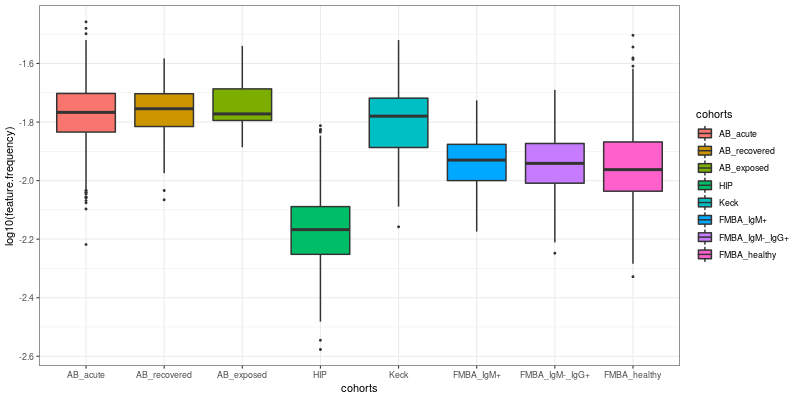

In [132]:
%%R -w 800 -h 400
AB_fmba_feat_freq_all_data=read.csv('AB_FMBA_mix_feat_freq_all_cohorts.tsv', sep="\t", header=TRUE)
AB_fmba_feat_freq_all_data$cohorts=factor(AB_fmba_feat_freq_all_data$cohorts,
                                          levels=c("AB_acute", "AB_recovered", "AB_exposed", "HIP",
                                                   "Keck", "FMBA_IgM+", "FMBA_IgM-_IgG+", "FMBA_healthy"))
#AB_fmba_feat_freq_all_data$features=as.factor(AB_fmba_feat_freq_all_data$features)

ggplot(AB_fmba_feat_freq_all_data, aes(x=cohorts, y=log10(feature.frequency), fill=cohorts) ) + 
  geom_boxplot( notch=FALSE,outlier.size = 0.7, lwd=0.7) + theme_bw()
    

### 4) Random AB clones

#### Take random public clones AB and get their frequences in FMBA data¶

In [123]:
%%time
folder_with_samples = "../../random_forest_v2/fmba_new_corr_TRB_functional_random2000AA"


#----------read sample names----------
samples=pd.read_csv(str(folder_with_samples)+"/metadata.txt",sep="\t",
                   header=None)
samples=list(samples[0])
#-------------------------------------


def get_features_frequences_levenshtein1_wrapper(sample_name,
                                                   path_to_folder_with_sample=folder_with_samples,
                                                   clones_for_analyse=random_clones_AB):
    return  get_features_frequences_levenshtein1(sample_name,
                                                  path_to_folder_with_sample=path_to_folder_with_sample,
                                                  clones_for_analyse=clones_for_analyse)




#result=list(map(get_features_frequences_levenshtein1_wrapper, samples))
print("START")    
pool = mp.Pool(processes = (mp.cpu_count())) #SET THE NUMBER OF CORES THAT YOU GOING TO USE
results=pool.map(get_features_frequences_levenshtein1_wrapper, samples)
pool.close()
clones_in_samples=list(results)
print("DONE")

START
DONE
CPU times: user 47.5 ms, sys: 425 ms, total: 473 ms
Wall time: 1min 5s


In [124]:
samples_short_names = list(map(lambda x: int(x[:12]), samples)) 
random_AB_freq_fmba = pd.DataFrame({'feature frequency': clones_in_samples}, index = samples_short_names)
random_AB_freq_fmba.index.name='sample_name'
random_AB_freq_fmba.to_csv('random_AB_freq_fmba.tsv', sep = '\t')

#### Take random public clones AB and get their frequences in AB data

In [125]:
%%time
folder_with_samples = "../../random_forest_v2/AB_corr_functional_random2000AA"


#----------read sample names----------
samples=pd.read_csv(str(folder_with_samples)+"/metadata.txt",sep="\t",
                   header=None)
samples=list(samples[0])
#-------------------------------------


def get_features_frequences_levenshtein1_wrapper(sample_name,
                                                   path_to_folder_with_sample=folder_with_samples,
                                                   clones_for_analyse=random_clones_AB):
    return  get_features_frequences_levenshtein1(sample_name,
                                                  path_to_folder_with_sample=path_to_folder_with_sample,
                                                  clones_for_analyse=clones_for_analyse)




#result=list(map(get_features_frequences_levenshtein1_wrapper, samples))
print("START")    
pool = mp.Pool(processes = (mp.cpu_count())) #SET THE NUMBER OF CORES THAT YOU GOING TO USE
results=pool.map(get_features_frequences_levenshtein1_wrapper, samples)
pool.close()
clones_in_samples=list(results)
print("DONE")

START
DONE
CPU times: user 78.5 ms, sys: 444 ms, total: 522 ms
Wall time: 1min 51s


In [126]:
samples_short_names = list(map(lambda x: x[: -13], samples)) 
random_AB_freq_AB = pd.DataFrame({'feature frequency': clones_in_samples}, index = samples_short_names)
random_AB_freq_AB.index.name='sample_name'
random_AB_freq_AB.to_csv('random_AB_freq_AB.tsv', sep = '\t')

#### Take random public clones AB and get their frequences in HIP and Keck data

In [127]:
%%time
folder_with_samples = "../../random_forest_v2/hip_corr_functional_random2000AA"


#----------read sample names----------
samples=pd.read_csv(str(folder_with_samples)+"/metadata.txt",sep="\t",
                   header=None)
samples=list(samples[0])
#-------------------------------------


def get_features_frequences_levenshtein1_wrapper(sample_name,
                                                   path_to_folder_with_sample=folder_with_samples,
                                                   clones_for_analyse=random_clones_AB):
    return  get_features_frequences_levenshtein1(sample_name,
                                                  path_to_folder_with_sample=path_to_folder_with_sample,
                                                  clones_for_analyse=clones_for_analyse)




#result=list(map(get_features_frequences_levenshtein1_wrapper, samples))
print("START")    
pool = mp.Pool(processes = (mp.cpu_count())) #SET THE NUMBER OF CORES THAT YOU GOING TO USE
results=pool.map(get_features_frequences_levenshtein1_wrapper, samples)
pool.close()
clones_in_samples=list(results)
print("DONE")

START
DONE
CPU times: user 10.9 ms, sys: 467 ms, total: 478 ms
Wall time: 1min 3s


In [128]:
samples_short_names = list(map(lambda x: x[: -4], samples)) 
random_AB_freq_HIP_Keck = pd.DataFrame({'feature frequency': clones_in_samples}, index = samples_short_names)
random_AB_freq_HIP_Keck.index.name='sample_name'
random_AB_freq_HIP_Keck.to_csv('random_AB_freq_HIP_Keck.tsv', sep = '\t')

In [129]:
#concat dataframes
random_AB_freq_all_data = pd.concat([random_AB_freq_fmba, random_AB_freq_AB, random_AB_freq_HIP_Keck], axis=0)

#Make a column with cohorts
random_AB_freq_all_data['cohorts'] = 'FMBA_healthy'
random_AB_freq_all_data.loc[set(random_AB_freq_all_data.index.values)&fmba_IgM_yes, 'cohorts'] = 'FMBA_IgM+'
random_AB_freq_all_data.loc[set(random_AB_freq_all_data.index.values)&fmba_IgM_no_IgG_yes, 'cohorts'] = 'FMBA_IgM-_IgG+'
random_AB_freq_all_data.loc[set(random_AB_freq_all_data.index.values)&AB_acute, 'cohorts'] = 'AB_acute'
random_AB_freq_all_data.loc[set(random_AB_freq_all_data.index.values)&AB_recovered, 'cohorts'] = 'AB_recovered'
random_AB_freq_all_data.loc[set(random_AB_freq_all_data.index.values)&AB_exposed, 'cohorts'] = 'AB_exposed'
random_AB_freq_all_data.loc[set(random_AB_freq_all_data.index.values)&hip, 'cohorts'] = 'HIP'
random_AB_freq_all_data.loc[set(random_AB_freq_all_data.index.values)&Keck, 'cohorts'] = 'Keck'
#fmba_healthy: 409
#fmba_IgM_yes: 410
#fmba_IgM_no_IgG_yes: 340
#AB_acute: 1140
#AB_recovered: 239
#AB_baseline: 74
#AB_exposed: 26
#HIP: 664
#Keck: 119
random_AB_freq_all_data.to_csv('random_AB_freq_all_cohorts.tsv', sep = '\t')

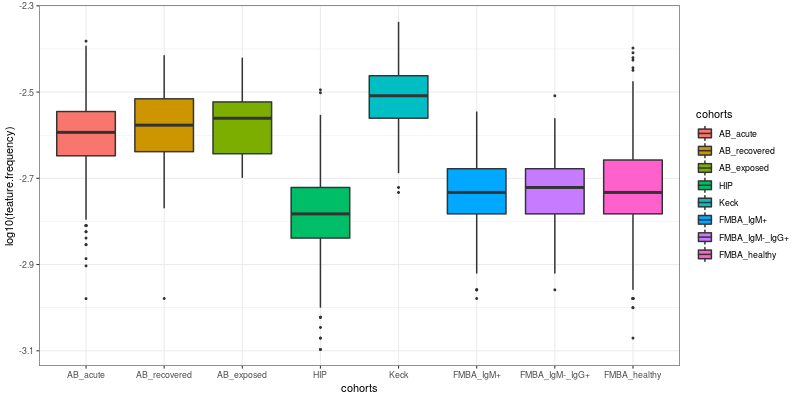

In [131]:
%%R -w 800 -h 400
random_AB_freq_all_data=read.csv('random_AB_freq_all_cohorts.tsv', sep="\t", header=TRUE)
random_AB_freq_all_data$cohorts=factor(random_AB_freq_all_data$cohorts,
                                          levels=c("AB_acute", "AB_recovered", "AB_exposed", "HIP",
                                                   "Keck", "FMBA_IgM+", "FMBA_IgM-_IgG+", "FMBA_healthy"))
#AB_fmba_feat_freq_all_data$features=as.factor(AB_fmba_feat_freq_all_data$features)

ggplot(random_AB_freq_all_data, aes(x=cohorts, y=log10(feature.frequency), fill=cohorts) ) + 
  geom_boxplot( notch=FALSE,outlier.size = 0.7, lwd=0.7) + theme_bw()

### 5) Random FMBA

#### Take random public clones FMBA and get their frequences in FMBA data¶

In [151]:
%%time
folder_with_samples = "../../random_forest_v2/fmba_new_corr_TRB_functional_random2000AA"


#----------read sample names----------
samples=pd.read_csv(str(folder_with_samples)+"/metadata.txt",sep="\t",
                   header=None)
samples=list(samples[0])
#-------------------------------------


def get_features_frequences_levenshtein1_wrapper(sample_name,
                                                   path_to_folder_with_sample=folder_with_samples,
                                                   clones_for_analyse=random_clones_FMBA):
    return  get_features_frequences_levenshtein1(sample_name,
                                                  path_to_folder_with_sample=path_to_folder_with_sample,
                                                  clones_for_analyse=clones_for_analyse)




#result=list(map(get_features_frequences_levenshtein1_wrapper, samples))
print("START")    
pool = mp.Pool(processes = (mp.cpu_count())) #SET THE NUMBER OF CORES THAT YOU GOING TO USE
results=pool.map(get_features_frequences_levenshtein1_wrapper, samples)
pool.close()
clones_in_samples=list(results)
print("DONE")

START
DONE
CPU times: user 35.3 ms, sys: 439 ms, total: 474 ms
Wall time: 1min 4s


In [144]:
samples_short_names = list(map(lambda x: int(x[:12]), samples)) 
random_FMBA_freq_fmba = pd.DataFrame({'feature frequency': clones_in_samples}, index = samples_short_names)
random_FMBA_freq_fmba.index.name='sample_name'
random_FMBA_freq_fmba.to_csv('random_FMBA_freq_fmba.tsv', sep = '\t')

#### Take random public clones FMBA and get their frequences in AB data

In [145]:
%%time
folder_with_samples = "../../random_forest_v2/AB_corr_functional_random2000AA"


#----------read sample names----------
samples=pd.read_csv(str(folder_with_samples)+"/metadata.txt",sep="\t",
                   header=None)
samples=list(samples[0])
#-------------------------------------


def get_features_frequences_levenshtein1_wrapper(sample_name,
                                                   path_to_folder_with_sample=folder_with_samples,
                                                   clones_for_analyse=random_clones_FMBA):
    return  get_features_frequences_levenshtein1(sample_name,
                                                  path_to_folder_with_sample=path_to_folder_with_sample,
                                                  clones_for_analyse=clones_for_analyse)




#result=list(map(get_features_frequences_levenshtein1_wrapper, samples))
print("START")    
pool = mp.Pool(processes = (mp.cpu_count())) #SET THE NUMBER OF CORES THAT YOU GOING TO USE
results=pool.map(get_features_frequences_levenshtein1_wrapper, samples)
pool.close()
clones_in_samples=list(results)
print("DONE")

START
DONE
CPU times: user 40.2 ms, sys: 442 ms, total: 482 ms
Wall time: 1min 50s


In [146]:
samples_short_names = list(map(lambda x: x[: -13], samples)) 
random_FMBA_freq_AB = pd.DataFrame({'feature frequency': clones_in_samples}, index = samples_short_names)
random_FMBA_freq_AB.index.name='sample_name'
random_FMBA_freq_AB.to_csv('random_FMBA_freq_AB.tsv', sep = '\t')

#### Take random public clones FMBA and get their frequences in HIP and Keck data

In [147]:
%%time
folder_with_samples = "../../random_forest_v2/hip_corr_functional_random2000AA"


#----------read sample names----------
samples=pd.read_csv(str(folder_with_samples)+"/metadata.txt",sep="\t",
                   header=None)
samples=list(samples[0])
#-------------------------------------


def get_features_frequences_levenshtein1_wrapper(sample_name,
                                                   path_to_folder_with_sample=folder_with_samples,
                                                   clones_for_analyse=random_clones_FMBA):
    return  get_features_frequences_levenshtein1(sample_name,
                                                  path_to_folder_with_sample=path_to_folder_with_sample,
                                                  clones_for_analyse=clones_for_analyse)




#result=list(map(get_features_frequences_levenshtein1_wrapper, samples))
print("START")    
pool = mp.Pool(processes = (mp.cpu_count())) #SET THE NUMBER OF CORES THAT YOU GOING TO USE
results=pool.map(get_features_frequences_levenshtein1_wrapper, samples)
pool.close()
clones_in_samples=list(results)
print("DONE")

START
DONE
CPU times: user 34.3 ms, sys: 428 ms, total: 462 ms
Wall time: 1min 3s


In [148]:
samples_short_names = list(map(lambda x: x[: -4], samples)) 
random_FMBA_freq_HIP_Keck = pd.DataFrame({'feature frequency': clones_in_samples}, index = samples_short_names)
random_FMBA_freq_HIP_Keck.index.name='sample_name'
random_FMBA_freq_HIP_Keck.to_csv('random_FMBA_freq_HIP_Keck.tsv', sep = '\t')

In [152]:
#concat dataframes
random_FMBA_freq_all_data = pd.concat([random_FMBA_freq_fmba, random_FMBA_freq_AB, random_FMBA_freq_HIP_Keck], axis=0)

#Make a column with cohorts
random_FMBA_freq_all_data['cohorts'] = 'FMBA_healthy'
random_FMBA_freq_all_data.loc[set(random_FMBA_freq_all_data.index.values)&fmba_IgM_yes, 'cohorts'] = 'FMBA_IgM+'
random_FMBA_freq_all_data.loc[set(random_FMBA_freq_all_data.index.values)&fmba_IgM_no_IgG_yes, 'cohorts'] = 'FMBA_IgM-_IgG+'
random_FMBA_freq_all_data.loc[set(random_FMBA_freq_all_data.index.values)&AB_acute, 'cohorts'] = 'AB_acute'
random_FMBA_freq_all_data.loc[set(random_FMBA_freq_all_data.index.values)&AB_recovered, 'cohorts'] = 'AB_recovered'
random_FMBA_freq_all_data.loc[set(random_FMBA_freq_all_data.index.values)&AB_exposed, 'cohorts'] = 'AB_exposed'
random_FMBA_freq_all_data.loc[set(random_FMBA_freq_all_data.index.values)&hip, 'cohorts'] = 'HIP'
random_FMBA_freq_all_data.loc[set(random_FMBA_freq_all_data.index.values)&Keck, 'cohorts'] = 'Keck'
#fmba_healthy: 409
#fmba_IgM_yes: 410
#fmba_IgM_no_IgG_yes: 340
#AB_acute: 1140
#AB_recovered: 239
#AB_baseline: 74
#AB_exposed: 26
#HIP: 664
#Keck: 119
random_FMBA_freq_all_data.to_csv('random_FMBA_freq_all_cohorts.tsv', sep = '\t')

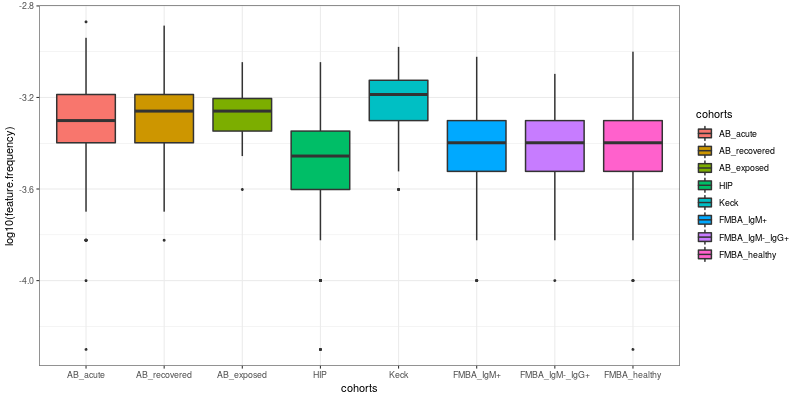

In [153]:
%%R -w 800 -h 400
random_FMBA_freq_all_data=read.csv('random_FMBA_freq_all_cohorts.tsv', sep="\t", header=TRUE)
random_FMBA_freq_all_data$cohorts=factor(random_FMBA_freq_all_data$cohorts,
                                          levels=c("AB_acute", "AB_recovered", "AB_exposed", "HIP",
                                                   "Keck", "FMBA_IgM+", "FMBA_IgM-_IgG+", "FMBA_healthy"))
#AB_fmba_feat_freq_all_data$features=as.factor(AB_fmba_feat_freq_all_data$features)

ggplot(random_FMBA_freq_all_data, aes(x=cohorts, y=log10(feature.frequency), fill=cohorts) ) + 
  geom_boxplot( notch=FALSE,outlier.size = 0.7, lwd=0.7) + theme_bw()

### 6) Associated clones FMBA founded by ttest

#### Get FMBA features frequences in FMBA data

In [35]:
%%time
#folder_with_samples = "../../random_forest_v2/fmba_new_corr_TRB_functional_random2000AA"


#----------read sample names----------
#samples=pd.read_csv(str(folder_with_samples)+"/metadata.txt",sep="\t",
#                   header=None)
#samples=list(samples[0])
#-------------------------------------
folder_with_samples="/projects/fmba_covid/fmba_new/corr"
chain="TRB"

#----------read sample names----------
samples=[i for i in os.listdir(folder_with_samples) if i.endswith(f"{chain}.txt")]
#-------------------------------------



def get_features_frequences_wrapper(sample_name,
                                                   path_to_folder_with_sample=folder_with_samples,
                                                   clones_for_analyse=associated_clones_fmba_ttest):
    return  get_features_frequences(sample_name,
                                                  path_to_folder_with_sample=path_to_folder_with_sample,
                                                  clones_for_analyse=clones_for_analyse)




#result=list(map(get_features_frequences_levenshtein1_wrapper, samples))
print("START")    
pool = mp.Pool(processes = (mp.cpu_count())) #SET THE NUMBER OF CORES THAT YOU GOING TO USE
results=pool.map(get_features_frequences_wrapper, samples)
pool.close()
clones_in_samples=list(results)
print("DONE")

START
DONE
CPU times: user 219 ms, sys: 701 ms, total: 920 ms
Wall time: 5.29 s


In [36]:
samples_short_names = list(map(lambda x: int(x[:12]), samples)) 
FMBA_ttest_freq_fmba = pd.DataFrame({'feature frequency': clones_in_samples}, index = samples_short_names)
FMBA_ttest_freq_fmba.index.name='sample_name'
FMBA_ttest_freq_fmba.to_csv('FMBA_ttest_freq_fmba.tsv', sep = '\t')

#### Get FMBA features frequences in Adaptive data

In [37]:
%%time
treshhold=2000
#folder_with_samples = "../../random_forest_v2/AB_corr_functional_random2000AA"


#----------read sample names----------
#samples=pd.read_csv(str(folder_with_samples)+"/metadata.txt",sep="\t",
#                   header=None)
#samples=list(samples[0])
#-------------------------------------
folder_with_samples="/projects/fmba_covid/adaptive_new/corr"


#----------read sample names----------
samples=os.listdir(folder_with_samples)
#-------------------------------------



def get_features_frequences_wrapper(sample_name,
                                                   path_to_folder_with_sample=folder_with_samples,
                                                   clones_for_analyse=associated_clones_fmba_ttest):
    return  get_features_frequences(sample_name,
                                                  path_to_folder_with_sample=path_to_folder_with_sample,
                                                  clones_for_analyse=clones_for_analyse)



#result=list(map(get_features_frequences_levenshtein1_wrapper, samples))
print("START")    
pool = mp.Pool(processes = (mp.cpu_count())) #SET THE NUMBER OF CORES THAT YOU GOING TO USE
results=pool.map(get_features_frequences_wrapper, samples)
pool.close()
clones_in_samples=list(results)
print("DONE")

START
DONE
CPU times: user 229 ms, sys: 966 ms, total: 1.2 s
Wall time: 11.5 s


In [38]:
samples_short_names = list(map(lambda x: x[: -13], samples)) 
FMBA_ttest_freq_AB = pd.DataFrame({'feature frequency': clones_in_samples}, index = samples_short_names)
FMBA_ttest_freq_AB.index.name='sample_name'
FMBA_ttest_freq_AB.to_csv('FMBA_ttest_freq_AB.tsv', sep = '\t')

#### Get FMBA features frequences in HIP, Keck data

In [39]:
%%time
#folder_with_samples = "../../random_forest_v2/hip_corr_functional_random2000AA"


#----------read sample names----------
#samples=pd.read_csv(str(folder_with_samples)+"/metadata.txt",sep="\t",
#                   header=None)
#samples=list(samples[0])
#-------------------------------------

folder_with_samples="/projects/fmba_covid/hip_full/corr"


#----------read sample names----------
samples=os.listdir(folder_with_samples)
#-------------------------------------

def get_features_frequences_wrapper(sample_name,
                                                   path_to_folder_with_sample=folder_with_samples,
                                                   clones_for_analyse=associated_clones_fmba_ttest):
    return  get_features_frequences(sample_name,
                                                  path_to_folder_with_sample=path_to_folder_with_sample,
                                                  clones_for_analyse=clones_for_analyse)



#result=list(map(get_features_frequences_levenshtein1_wrapper, samples))
print("START")    
pool = mp.Pool(processes = (mp.cpu_count())) #SET THE NUMBER OF CORES THAT YOU GOING TO USE
results=pool.map(get_features_frequences_wrapper, samples)
pool.close()
clones_in_samples=list(results)
print("DONE")

START
DONE
CPU times: user 231 ms, sys: 809 ms, total: 1.04 s
Wall time: 7.24 s


In [40]:
samples_short_names = list(map(lambda x: x[: -4], samples)) 
FMBA_ttest_freq_HIP_Keck = pd.DataFrame({'feature frequency': clones_in_samples}, index = samples_short_names)
FMBA_ttest_freq_HIP_Keck.index.name='sample_name'
FMBA_ttest_freq_HIP_Keck.to_csv('FMBA_ttest_freq_HIP_Keck.tsv', sep = '\t')

In [41]:
#concat dataframes
FMBA_ttest_freq_all_data = pd.concat([FMBA_ttest_freq_fmba, FMBA_ttest_freq_AB, FMBA_ttest_freq_HIP_Keck], axis=0)

#Make a column with cohorts
FMBA_ttest_freq_all_data['cohorts'] = 'FMBA_healthy'
FMBA_ttest_freq_all_data.loc[set(FMBA_ttest_freq_all_data.index.values)&fmba_IgM_yes, 'cohorts'] = 'FMBA_IgM+'
FMBA_ttest_freq_all_data.loc[set(FMBA_ttest_freq_all_data.index.values)&fmba_IgM_no_IgG_yes, 'cohorts'] = 'FMBA_IgM-_IgG+'
FMBA_ttest_freq_all_data.loc[set(FMBA_ttest_freq_all_data.index.values)&AB_acute, 'cohorts'] = 'AB_acute'
FMBA_ttest_freq_all_data.loc[set(FMBA_ttest_freq_all_data.index.values)&AB_recovered, 'cohorts'] = 'AB_recovered'
FMBA_ttest_freq_all_data.loc[set(FMBA_ttest_freq_all_data.index.values)&AB_exposed, 'cohorts'] = 'AB_exposed'
FMBA_ttest_freq_all_data.loc[set(FMBA_ttest_freq_all_data.index.values)&hip, 'cohorts'] = 'HIP'
FMBA_ttest_freq_all_data.loc[set(FMBA_ttest_freq_all_data.index.values)&Keck, 'cohorts'] = 'Keck'
#fmba_healthy: 409
#fmba_IgM_yes: 410
#fmba_IgM_no_IgG_yes: 340
#AB_acute: 1140
#AB_recovered: 239
#AB_baseline: 74
#AB_exposed: 26
#HIP: 664
#Keck: 119
FMBA_ttest_freq_all_data.to_csv('FMBA_ttest_freq_all_cohorts.tsv', sep = '\t')

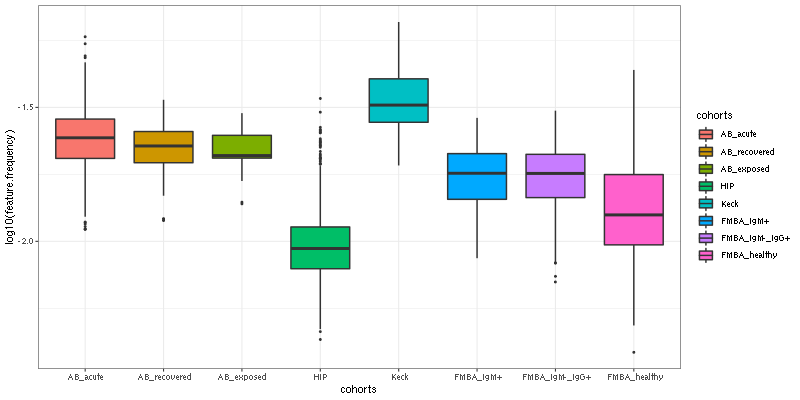

In [20]:
%%R -w 800 -h 400
FMBA_ttest_freq_all_data=read.csv('FMBA_ttest_freq_all_cohorts.tsv', sep="\t", header=TRUE)
FMBA_ttest_freq_all_data$cohorts=factor(FMBA_ttest_freq_all_data$cohorts,
                                          levels=c("AB_acute", "AB_recovered", "AB_exposed", "HIP",
                                                   "Keck", "FMBA_IgM+", "FMBA_IgM-_IgG+", "FMBA_healthy"))
#AB_fmba_feat_freq_all_data$features=as.factor(AB_fmba_feat_freq_all_data$features)

ggplot(FMBA_ttest_freq_all_data, aes(x=cohorts, y=log10(feature.frequency), fill=cohorts) ) + 
  geom_boxplot( notch=FALSE,outlier.size = 0.7, lwd=0.7) + theme_bw()
#Downsampling top2000, leven1 

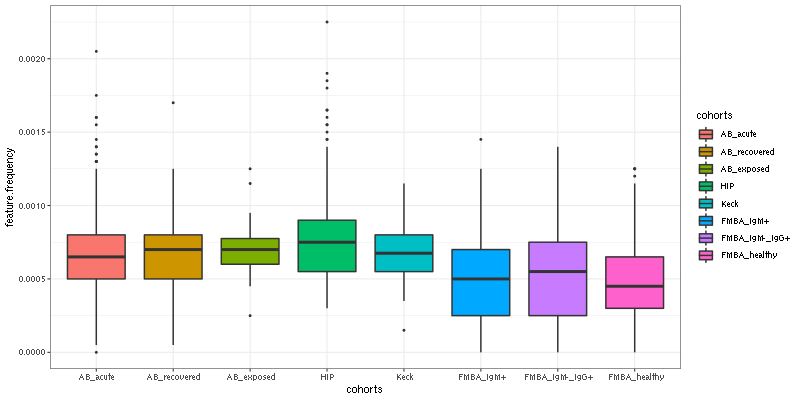

In [42]:
%%R -w 800 -h 400
FMBA_ttest_freq_all_data=read.csv('FMBA_ttest_freq_all_cohorts.tsv', sep="\t", header=TRUE)
FMBA_ttest_freq_all_data$cohorts=factor(FMBA_ttest_freq_all_data$cohorts,
                                          levels=c("AB_acute", "AB_recovered", "AB_exposed", "HIP",
                                                   "Keck", "FMBA_IgM+", "FMBA_IgM-_IgG+", "FMBA_healthy"))
#AB_fmba_feat_freq_all_data$features=as.factor(AB_fmba_feat_freq_all_data$features)

ggplot(FMBA_ttest_freq_all_data, aes(x=cohorts, y=feature.frequency, fill=cohorts) ) + 
  geom_boxplot( notch=FALSE,outlier.size = 0.7, lwd=0.7) + theme_bw()
#Initial data, top2000, without mismatch

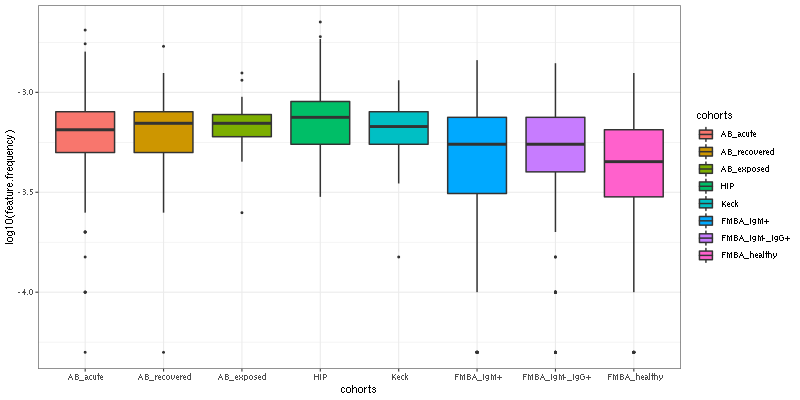

In [43]:
%%R -w 800 -h 400
FMBA_ttest_freq_all_data=read.csv('FMBA_ttest_freq_all_cohorts.tsv', sep="\t", header=TRUE)
FMBA_ttest_freq_all_data$cohorts=factor(FMBA_ttest_freq_all_data$cohorts,
                                          levels=c("AB_acute", "AB_recovered", "AB_exposed", "HIP",
                                                   "Keck", "FMBA_IgM+", "FMBA_IgM-_IgG+", "FMBA_healthy"))
#AB_fmba_feat_freq_all_data$features=as.factor(AB_fmba_feat_freq_all_data$features)

ggplot(FMBA_ttest_freq_all_data, aes(x=cohorts, y=log10(feature.frequency), fill=cohorts) ) + 
  geom_boxplot( notch=FALSE,outlier.size = 0.7, lwd=0.7) + theme_bw()
#Initial data, top2000, without mismatch

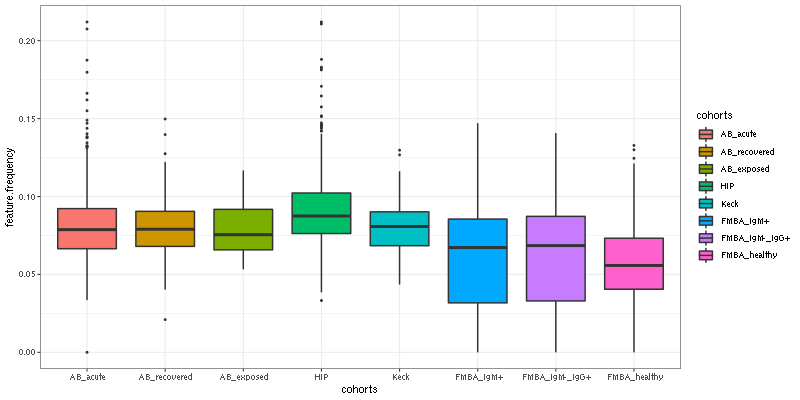

In [32]:
%%R -w 800 -h 400
FMBA_ttest_freq_all_data=read.csv('FMBA_ttest_freq_all_cohorts.tsv', sep="\t", header=TRUE)
FMBA_ttest_freq_all_data$cohorts=factor(FMBA_ttest_freq_all_data$cohorts,
                                          levels=c("AB_acute", "AB_recovered", "AB_exposed", "HIP",
                                                   "Keck", "FMBA_IgM+", "FMBA_IgM-_IgG+", "FMBA_healthy"))
#AB_fmba_feat_freq_all_data$features=as.factor(AB_fmba_feat_freq_all_data$features)

ggplot(FMBA_ttest_freq_all_data, aes(x=cohorts, y=feature.frequency, fill=cohorts) ) + 
  geom_boxplot( notch=FALSE,outlier.size = 0.7, lwd=0.7) + theme_bw()
#initial data, top2000, hamming

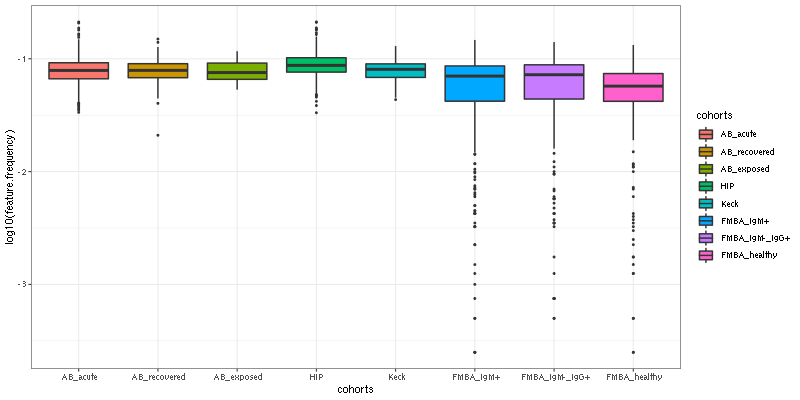

In [34]:
%%R -w 800 -h 400
FMBA_ttest_freq_all_data=read.csv('FMBA_ttest_freq_all_cohorts.tsv', sep="\t", header=TRUE)
FMBA_ttest_freq_all_data$cohorts=factor(FMBA_ttest_freq_all_data$cohorts,
                                          levels=c("AB_acute", "AB_recovered", "AB_exposed", "HIP",
                                                   "Keck", "FMBA_IgM+", "FMBA_IgM-_IgG+", "FMBA_healthy"))
#AB_fmba_feat_freq_all_data$features=as.factor(AB_fmba_feat_freq_all_data$features)

ggplot(FMBA_ttest_freq_all_data, aes(x=cohorts, y=log10(feature.frequency), fill=cohorts) ) + 
  geom_boxplot( notch=FALSE,outlier.size = 0.7, lwd=0.7) + theme_bw()
#Initial data, top2000, hamming, log-scale

### 7) Associated clones FMBA TRA founded by ttest

In [40]:
%%time
treshhold=2000
folder_with_samples = "/projects/fmba_covid/fmba_new/corr"


#----------read sample names----------
samples=[i for i in os.listdir("/projects/fmba_covid/fmba_new/corr") if i.endswith("TRA.txt")]
#-------------------------------------


def get_features_frequences_hamming_wrapper(sample_name,
                                                   path_to_folder_with_sample=folder_with_samples,
                                                   clones_for_analyse=associated_clones_fmba_tra_ttest):
    return  get_features_frequences_hamming(sample_name,
                                                  path_to_folder_with_sample=path_to_folder_with_sample,
                                                  clones_for_analyse=clones_for_analyse)




#result=list(map(get_features_frequences_levenshtein1_wrapper, samples))
print("START")    
pool = mp.Pool(processes = (mp.cpu_count())) #SET THE NUMBER OF CORES THAT YOU GOING TO USE
results=pool.map(get_features_frequences_hamming_wrapper, samples)
pool.close()
clones_in_samples=list(results)
print("DONE")

START
DONE
CPU times: user 484 ms, sys: 1.08 s, total: 1.56 s
Wall time: 45.9 s


In [41]:
samples_short_names = list(map(lambda x: int(x[:12]), samples)) 
FMBA_tra_ttest_freq_fmba = pd.DataFrame({'feature frequency': clones_in_samples}, index = samples_short_names)
FMBA_tra_ttest_freq_fmba.index.name='sample_name'
FMBA_tra_ttest_freq_fmba.to_csv('FMBA_tra_ttest_freq_fmba.tsv', sep = '\t')

In [45]:
#Make a column with cohorts
FMBA_tra_ttest_freq_fmba['cohorts'] = 'FMBA_healthy'
FMBA_tra_ttest_freq_fmba.loc[set(FMBA_tra_ttest_freq_fmba.index.values)&fmba_IgM_yes, 'cohorts'] = 'FMBA_IgM+'
FMBA_tra_ttest_freq_fmba.loc[set(FMBA_tra_ttest_freq_fmba.index.values)&fmba_IgM_no_IgG_yes, 'cohorts'] = 'FMBA_IgM-_IgG+'

FMBA_tra_ttest_freq_fmba.to_csv('FMBA_tra_ttest_freq_fmba_cohorts.tsv', sep = '\t')

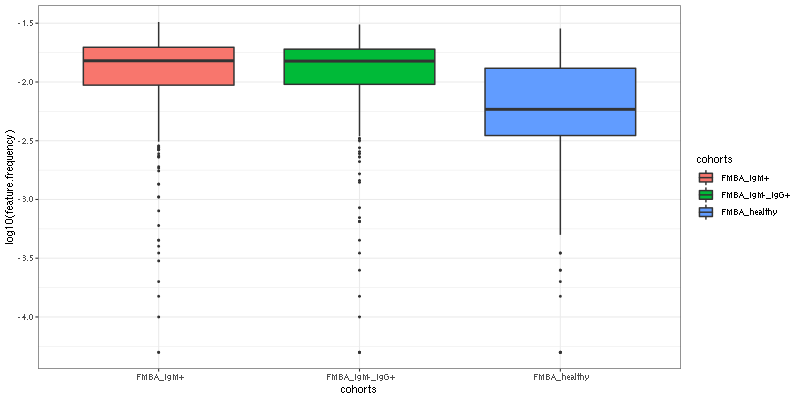

In [50]:
%%R -w 800 -h 400
FMBA_tra_ttest_freq_fmba=read.csv('FMBA_tra_ttest_freq_fmba_cohorts.tsv', sep="\t", header=TRUE)
FMBA_tra_ttest_freq_fmba$cohorts=factor(FMBA_tra_ttest_freq_fmba$cohorts,
                                          levels=c("FMBA_IgM+", "FMBA_IgM-_IgG+", "FMBA_healthy"))
#AB_fmba_feat_freq_all_data$features=as.factor(AB_fmba_feat_freq_all_data$features)

ggplot(FMBA_tra_ttest_freq_fmba, aes(x=cohorts, y=log10(feature.frequency), fill=cohorts) ) + 
  geom_boxplot( notch=FALSE,outlier.size = 0.7, lwd=0.7) + theme_bw()

#### Without mismach  

In [59]:
%%time
treshhold=2000
folder_with_samples = "/projects/fmba_covid/fmba_new/corr"


#----------read sample names----------
samples=[i for i in os.listdir("/projects/fmba_covid/fmba_new/corr") if i.endswith("TRA.txt")]
#-------------------------------------


def get_features_frequences_wrapper(sample_name,
                                                   path_to_folder_with_sample=folder_with_samples,
                                                   clones_for_analyse=associated_clones_fmba_tra_ttest):
    return  get_features_frequences(sample_name,
                                                  path_to_folder_with_sample=path_to_folder_with_sample,
                                                  clones_for_analyse=clones_for_analyse)




#result=list(map(get_features_frequences_levenshtein1_wrapper, samples))
print("START")    
pool = mp.Pool(processes = (mp.cpu_count())) #SET THE NUMBER OF CORES THAT YOU GOING TO USE
results=pool.map(get_features_frequences_wrapper, samples)
pool.close()
clones_in_samples=list(results)
print("DONE")

START
DONE
CPU times: user 133 ms, sys: 580 ms, total: 713 ms
Wall time: 5.84 s


In [60]:
samples_short_names = list(map(lambda x: int(x[:12]), samples)) 
FMBA_tra_ttest_freq_fmba = pd.DataFrame({'feature frequency': clones_in_samples}, index = samples_short_names)
FMBA_tra_ttest_freq_fmba.index.name='sample_name'
FMBA_tra_ttest_freq_fmba.to_csv('FMBA_tra_ttest_freq_fmba_without_mismath.tsv', sep = '\t')

In [61]:
#Make a column with cohorts
FMBA_tra_ttest_freq_fmba['cohorts'] = 'FMBA_healthy'
FMBA_tra_ttest_freq_fmba.loc[set(FMBA_tra_ttest_freq_fmba.index.values)&fmba_IgM_yes, 'cohorts'] = 'FMBA_IgM+'
FMBA_tra_ttest_freq_fmba.loc[set(FMBA_tra_ttest_freq_fmba.index.values)&fmba_IgM_no_IgG_yes, 'cohorts'] = 'FMBA_IgM-_IgG+'

FMBA_tra_ttest_freq_fmba.to_csv('FMBA_tra_ttest_freq_fmba_cohorts_without_mismath.tsv', sep = '\t')

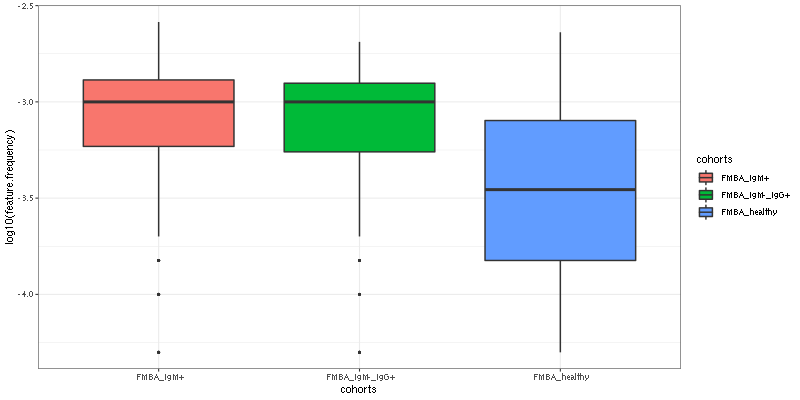

In [63]:
%%R -w 800 -h 400
FMBA_tra_ttest_freq_fmba=read.csv('FMBA_tra_ttest_freq_fmba_cohorts_without_mismath.tsv', sep="\t", header=TRUE)
FMBA_tra_ttest_freq_fmba$cohorts=factor(FMBA_tra_ttest_freq_fmba$cohorts,
                                          levels=c("FMBA_IgM+", "FMBA_IgM-_IgG+", "FMBA_healthy"))
#AB_fmba_feat_freq_all_data$features=as.factor(AB_fmba_feat_freq_all_data$features)

ggplot(FMBA_tra_ttest_freq_fmba, aes(x=cohorts, y=log10(feature.frequency), fill=cohorts) ) + 
  geom_boxplot( notch=FALSE,outlier.size = 0.7, lwd=0.7) + theme_bw()

### 8) Associated clones FMBA TRA founded by Fisher

In [54]:
%%time
treshhold=2000
folder_with_samples = "/projects/fmba_covid/fmba_new/corr"


#----------read sample names----------
samples=[i for i in os.listdir("/projects/fmba_covid/fmba_new/corr") if i.endswith("TRA.txt")]
#-------------------------------------


def get_features_frequences_hamming_wrapper(sample_name,
                                                   path_to_folder_with_sample=folder_with_samples,
                                                   clones_for_analyse=associated_clones_fmba_tra_fisher):
    return  get_features_frequences_hamming(sample_name,
                                                  path_to_folder_with_sample=path_to_folder_with_sample,
                                                  clones_for_analyse=clones_for_analyse)




#result=list(map(get_features_frequences_levenshtein1_wrapper, samples))
print("START")    
pool = mp.Pool(processes = (mp.cpu_count())) #SET THE NUMBER OF CORES THAT YOU GOING TO USE
results=pool.map(get_features_frequences_hamming_wrapper, samples)
pool.close()
clones_in_samples=list(results)
print("DONE")

START
DONE
CPU times: user 202 ms, sys: 609 ms, total: 811 ms
Wall time: 10.7 s


In [55]:
samples_short_names = list(map(lambda x: int(x[:12]), samples)) 
FMBA_tra_ttest_freq_fmba = pd.DataFrame({'feature frequency': clones_in_samples}, index = samples_short_names)
FMBA_tra_ttest_freq_fmba.index.name='sample_name'
FMBA_tra_ttest_freq_fmba.to_csv('FMBA_tra_fisher_freq_fmba.tsv', sep = '\t')

In [56]:
#Make a column with cohorts
FMBA_tra_ttest_freq_fmba['cohorts'] = 'FMBA_healthy'
FMBA_tra_ttest_freq_fmba.loc[set(FMBA_tra_ttest_freq_fmba.index.values)&fmba_IgM_yes, 'cohorts'] = 'FMBA_IgM+'
FMBA_tra_ttest_freq_fmba.loc[set(FMBA_tra_ttest_freq_fmba.index.values)&fmba_IgM_no_IgG_yes, 'cohorts'] = 'FMBA_IgM-_IgG+'

FMBA_tra_ttest_freq_fmba.to_csv('FMBA_tra_fisher_freq_fmba_cohorts.tsv', sep = '\t')

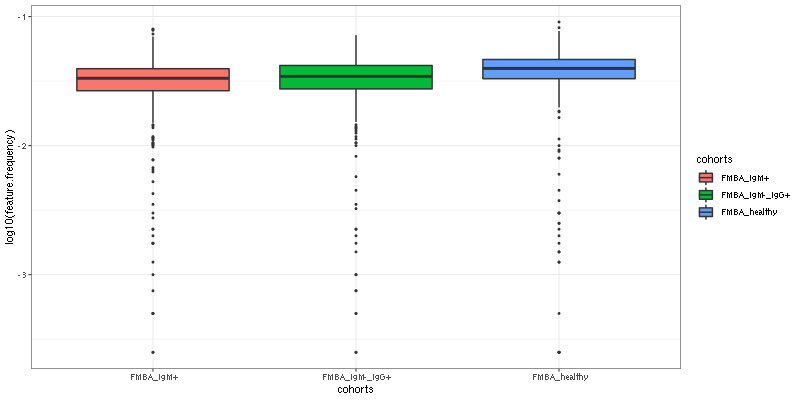

In [57]:
%%R -w 800 -h 400
FMBA_tra_ttest_freq_fmba=read.csv('FMBA_tra_fisher_freq_fmba_cohorts.tsv', sep="\t", header=TRUE)
FMBA_tra_ttest_freq_fmba$cohorts=factor(FMBA_tra_ttest_freq_fmba$cohorts,
                                          levels=c("FMBA_IgM+", "FMBA_IgM-_IgG+", "FMBA_healthy"))
#AB_fmba_feat_freq_all_data$features=as.factor(AB_fmba_feat_freq_all_data$features)

ggplot(FMBA_tra_ttest_freq_fmba, aes(x=cohorts, y=log10(feature.frequency), fill=cohorts) ) + 
  geom_boxplot( notch=FALSE,outlier.size = 0.7, lwd=0.7) + theme_bw()

#### Without mismath 

In [65]:
%%time
treshhold=2000
folder_with_samples = "/projects/fmba_covid/fmba_new/corr"


#----------read sample names----------
samples=[i for i in os.listdir("/projects/fmba_covid/fmba_new/corr") if i.endswith("TRA.txt")]
#-------------------------------------


def get_features_frequences_wrapper(sample_name,
                                                   path_to_folder_with_sample=folder_with_samples,
                                                   clones_for_analyse=associated_clones_fmba_tra_fisher):
    return  get_features_frequences(sample_name,
                                                  path_to_folder_with_sample=path_to_folder_with_sample,
                                                  clones_for_analyse=clones_for_analyse)




#result=list(map(get_features_frequences_levenshtein1_wrapper, samples))
print("START")    
pool = mp.Pool(processes = (mp.cpu_count())) #SET THE NUMBER OF CORES THAT YOU GOING TO USE
results=pool.map(get_features_frequences_wrapper, samples)
pool.close()
clones_in_samples=list(results)
print("DONE")

START
DONE
CPU times: user 106 ms, sys: 530 ms, total: 636 ms
Wall time: 2.01 s


In [66]:
samples_short_names = list(map(lambda x: int(x[:12]), samples)) 
FMBA_tra_ttest_freq_fmba = pd.DataFrame({'feature frequency': clones_in_samples}, index = samples_short_names)
FMBA_tra_ttest_freq_fmba.index.name='sample_name'
FMBA_tra_ttest_freq_fmba.to_csv('FMBA_tra_fisher_freq_fmba_without_mismath.tsv', sep = '\t')

In [67]:
#Make a column with cohorts
FMBA_tra_ttest_freq_fmba['cohorts'] = 'FMBA_healthy'
FMBA_tra_ttest_freq_fmba.loc[set(FMBA_tra_ttest_freq_fmba.index.values)&fmba_IgM_yes, 'cohorts'] = 'FMBA_IgM+'
FMBA_tra_ttest_freq_fmba.loc[set(FMBA_tra_ttest_freq_fmba.index.values)&fmba_IgM_no_IgG_yes, 'cohorts'] = 'FMBA_IgM-_IgG+'

FMBA_tra_ttest_freq_fmba.to_csv('FMBA_tra_fisher_freq_fmba_cohorts_without_mismath.tsv', sep = '\t')

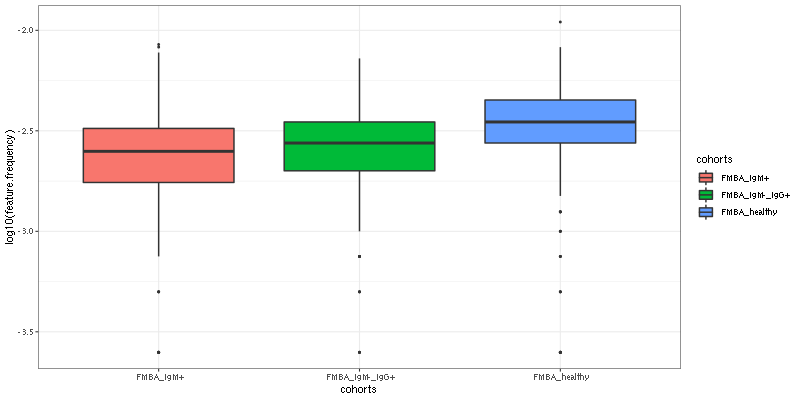

In [68]:
%%R -w 800 -h 400
FMBA_tra_ttest_freq_fmba=read.csv('FMBA_tra_fisher_freq_fmba_cohorts_without_mismath.tsv', sep="\t", header=TRUE)
FMBA_tra_ttest_freq_fmba$cohorts=factor(FMBA_tra_ttest_freq_fmba$cohorts,
                                          levels=c("FMBA_IgM+", "FMBA_IgM-_IgG+", "FMBA_healthy"))
#AB_fmba_feat_freq_all_data$features=as.factor(AB_fmba_feat_freq_all_data$features)

ggplot(FMBA_tra_ttest_freq_fmba, aes(x=cohorts, y=log10(feature.frequency), fill=cohorts) ) + 
  geom_boxplot( notch=FALSE,outlier.size = 0.7, lwd=0.7) + theme_bw()